In [1]:
import torch

import pickle

import sys
import os

from cell_dataset import load
from cell_utils import  make_animation
from cell_training import run_single, run_single_recursive
from cell_model import Gatv2Predictor, ConvPredictor

import matplotlib.pyplot as plt

import os, psutil
process = psutil.Process(os.getpid())
print("Using : ", process.memory_info().rss // 1000000)  # in megabytes 
print("Available : ", process.memory_info().vms  // 1000000)  # in megabytes 

print(torch.cuda.is_available())

from genericpath import exists

#https://github.com/clovaai/AdamP
from adamp import AdamP

sys.path.append('/home/nstillman/1_sbi_activematter/cpp_model')
try :
    import allium
except :
    print("Could not import allium")

c:\Users\gille\miniconda3\envs\geom\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using :  290
Available :  3271
True
Could not import allium


In [2]:
load_all =  True#load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

extension = "_open_ht_hv"
epoch = 0

model_path = "models/" + extension[1:] + "/model" + extension + "_" + str(epoch)

print(model_path)

override = False #make this true to always use the same ones

data_train, data_test, data_val = load(load_all, extension, pre_separated, override)

models/open_ht_hv/model_open_ht_hv_0
Validation data not found


In [3]:
#INFO : if bg_load is True, this starts the loading, if skipped, bg_loading will take place as soon as a get is called
rval, edge_index, edge_attr, border, params = data_test.get(0)

In [3]:
model = Gatv2Predictor(in_channels=16, out_channels=4, hidden_channels=64, dropout=0.05, edge_dim=2, messages=10, wrap=data_train.wrap)
#model = GraphEvolution(in_channels=9, out_channels=4, hidden_channels=32, dropout=0.01, edge_dim=2, messages=5, wrap=True)
if exists(model_path + ".pt") :
    with open(model_path + ".pt", "rb") as f:
        model.load_state_dict(torch.load(f))
        #since we loaded the state dict, we need to recompile the model
        print("Loaded model from ", model_path)
     

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.eval()

Loaded model from  models/open_ht_hv/model_open_ht_hv_0


GraphEvolution(
  (encoder_resize): Linear(in_features=14, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
        (dropout2): Dropout(p=0.05, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_fea

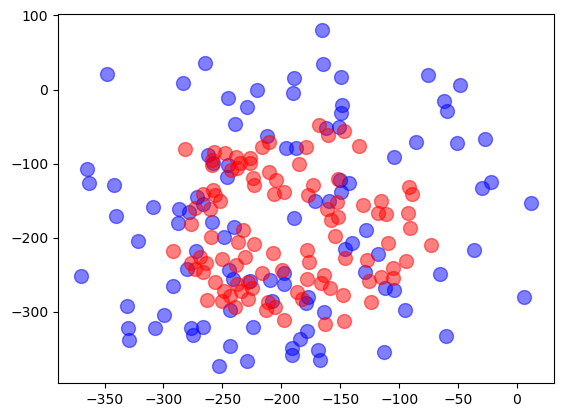

In [4]:
loss_history = {'loss_mean' : [], 'loss_log' : []}
loss, out, x = run_single_recursive(model, data_test, 0, device, loss_history, output=True)

if out == None or x == None :
    raise Exception("No output")

with open("models/" + extension[1:] + "/result_recursive_" + str(epoch) + ".pkl", "wb") as f:
    pickle.dump((out, x), f)

t = 10
fig = plt.figure()

#now plot the graph as bubbles to show the difference between the two
plt.scatter(x[t, :,0],x[t, :,1], s=100, c='b', alpha=0.5)
plt.scatter(out[t, :,0],out[t, :,1], s=100, c='r', alpha=0.5)

plt.show()
plt.close()

#show an arrow for the speed
#plt.quiver(x[t, :, 0], x[t, :, 1], x[t, :, 2], x[t, :, 3],color='b', alpha=0.5)
#plt.quiver(out[t, :, 0], out[t, :, 1], out[t, :, 2], out[t, :, 3],color='r', alpha=0.5)

In [6]:
loss_history = {'loss_mean' : [], 'loss_log' : []}
loss, out, x = run_single(model, data_test, 0, device, loss_history, output=True)

if out == None or x == None :
    raise Exception("No output")

with open("models/" + extension[1:] + "/result_" + str(epoch) + ".pkl", "wb") as f:
    pickle.dump((out, x), f)

t = 10
fig = plt.figure()

#now plot the graph as bubbles to show the difference between the two
plt.scatter(x[t, :,0],x[t, :,1], s=100, c='b', alpha=0.5)
plt.scatter(out[t, :,0],out[t, :,1], s=100, c='r', alpha=0.5)

plt.show()
plt.close()
#show an arrow for the speed
#plt.quiver(x[t, :, 0], x[t, :, 1], x[t, :, 2], x[t, :, 3],color='b', alpha=0.5)
#plt.quiver(out[t, :, 0], out[t, :, 1], out[t, :, 2], out[t, :, 3],color='r', alpha=0.5)

RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 10.00 GiB total capacity; 9.10 GiB already allocated; 0 bytes free; 9.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
raise Exception("Need ffmpeg to continue")

Exception: Need ffmpeg to continue

In [7]:

extension = "_open_hv_ht"
epoch = 210

In [1]:
from cell_utils import  make_animation
from cell_utils import singleCellTrajectoryAnimation
from genericpath import exists

possible_extensions = ["_open_ht_lv", "_wrapped", "_wrapped_v2", "_random_sample", "_open_lt_lv", "_open_lt_hv", "_open_ht_hv"]
possible_epochs = [0, 50, 100, 150]

for ext in possible_extensions :
    for epo in possible_epochs :
        if exists("models/" + ext[1:] + "/result_recursive_" + str(epo) + ".pkl") :
            result_name = "models/" + ext[1:]  + "/result_recursive_" + str(epo) + ".pkl"
            animation_name = "models/" + ext[1:]  + "/animation_recursive_" + str(epo) + ".mp4"
            make_animation(result_name, animation_name, show_speed=False)
            
            animation_name = "models/" + ext[1:]  + "/animation_recursive_traj_" + str(epo) + ".mp4"
            singleCellTrajectoryAnimation(result_name, animation_name, show_speed=False)
            
        if exists("models/" + ext[1:] + "/result_" + str(epo) + ".pkl") :
            result_name = "models/" + ext[1:]  + "/result_" + str(epo) + ".pkl"
            animation_name = "models/" + ext[1:]  + "/animation_" + str(epo) + ".mp4"
            make_animation(result_name, animation_name, show_speed=False)
            
            animation_name = "models/" + ext[1:]  + "/animation_traj_" + str(epo) + ".mp4"
            singleCellTrajectoryAnimation(result_name, animation_name, show_speed=False)

c:\Users\gille\miniconda3\envs\geom\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
